In [2]:
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
import tensorflow as tf
from glob import glob
import numpy as np
import pickle
from tqdm import tqdm

%matplotlib inline

In [3]:
# Programme structure
#---------------------
# 1. Import binary masks and images.
# 2. Get indices of pixels corresponding to cracks.
# 3. Define a KxK kernel.
# 4. Extract KxK windows of pixels centered on the crack pixels that satisfy:
#          4 * # Crack px. > # Nocrack px.
# 5. The number of 'crack' windows is m.
# 6. Sample m nocrack windows: take the range 
#              [0 + r, image_size - r, m/52]
#    where r is a random integer less than 20. Test the indices gathered.
#    If a window fails, increment one of the indices until it succeeds (captures 'edge' cases).
# 7. Assign the windows unique IDs and one-hot encoded labels.
# 8. Split the data into training, testing, and validation sets.
# 9. Pickle these sets to the EBS storage (mount it first!).

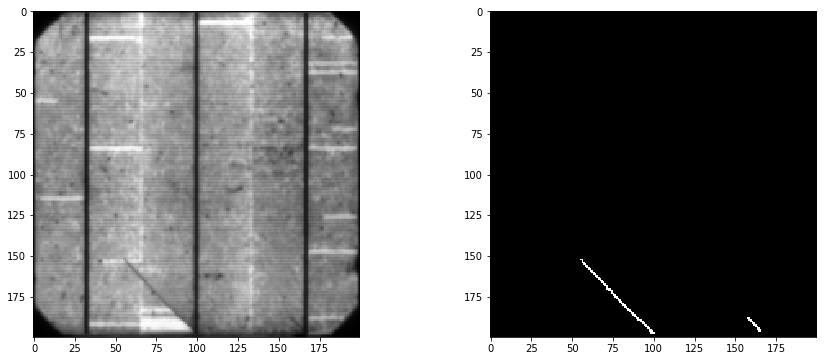

In [7]:
# 1. Import binary masks and images.
image_size = [200, 200]
all_images = np.array([imresize(imread(fp).astype(np.uint8), image_size)
                       for fp in glob('../data/resized-images/*.png')])
all_masks  = np.array([(imresize(imread(fp), image_size) > 30).astype(int)
                       for fp in glob('../data/masked-images/*.png')])

# Split off the last ten images for testing purposes
images = {'test':all_images[44:, :, :], 'train':all_images[:44, :, :]};
masks  = {'test':all_masks[44:, :, :],  'train':all_masks[:44, :, :]};

f, axs = plt.subplots(1, 2, figsize = (15, 6))
axs[0].imshow(images['train'][23], cmap = 'gray'); axs[1].imshow(masks['train'][23], cmap='gray');

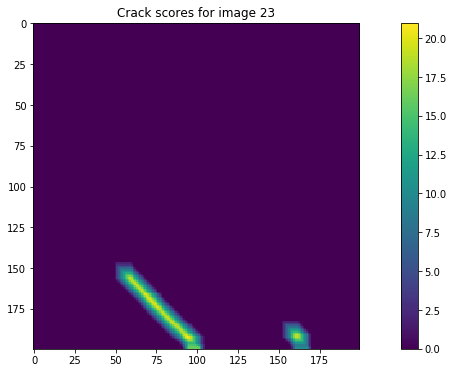

In [8]:
# 3. Define a KxK kernel. We use a 20 x 20px one based on measurements of the crack dimensions (See the report).
K      = 10
kernel = np.ones([1, K, K])

# 4. Convolve the kernel with each image to obtain crack scores for each 10x10 patch in an image.
crack_scores = {'train':convolve(masks['train'], kernel),
                'test':convolve(masks['test'], kernel)}

# Plot them
plt.figure(figsize = (15, 6))
plt.imshow(crack_scores['train'][23]); plt.title('Crack scores for image 23'); plt.colorbar();

In [25]:
def sample_patches(images, ix, K):
    # ix is a matrix whose rows correspond to [img_no, px_row, px_col]
    patches = np.zeros([ix.shape[0], K, K], np.uint8)
    img = images[ix[0, :][0]]
    pimg = np.pad(img, pad_width = [[K, K], [K, K]],
                                 mode = 'constant', constant_values = 0)
    for j, px_ix in enumerate(ix):
        if np.any(img != images[px_ix[0]]):
            img = images[px_ix[0]]
            pimg = np.pad(img, pad_width = [[K, K], [K, K]],
                                 mode = 'constant', constant_values = 0)
        patches[j, :, :] = pimg[px_ix[1] + K//2 : px_ix[1] + (3 * K // 2),
                                        px_ix[2] + K//2 : px_ix[2] + (3 * K // 2)]
    return patches


def random_patches(images, mask, n_samples, K):
    mask_ix = np.array(np.nonzero(mask)).T
    rnd_ix  = np.random.choice(range(mask_ix.shape[0]), n_samples, replace = False)
    return sample_patches(images, mask_ix[rnd_ix, :], K)

def scale_and_center(images, mean, std):
    return (images - mean)  / std

def validation_split(images, labels, train_frac=0.8):
    mask           = np.array([False]*labels.shape[0])
    rnd_ix         = np.random.choice(range(mask.shape[0]), int(train_frac * labels.shape[0]), replace = False)
    mask[rnd_ix]   = True
    train_images   = images[mask, :, :]
    train_labels   = labels[mask, :]
    valid_images   = images[np.logical_not(mask), :, :]
    valid_labels   = labels[np.logical_not(mask), :]
    return train_images, valid_images, train_labels, valid_labels

def pickle_data(data, labels, name):
    pickle.dump(data, open('../data/' + name + '_dataset.p', 'wb'))
    pickle.dump(labels, open('../data/' + name + '_labels.p', 'wb'))

In [26]:
# 5. Extract all windows with crack scores greater than a threshold (we use 20% of the maximum).
score_threshold      = 0.2 * K * K
n_samples            = np.sum(crack_scores['train'] >= score_threshold)
patch_data           = {}

# Get a random balanced subset of training patches
patch_data['cracks']   = random_patches(images['train'], crack_scores['train'] >= score_threshold, n_samples, K)
patch_data['nocracks'] = random_patches(images['train'], crack_scores['train'] < score_threshold, n_samples, K)

# 7. Scale and center the training/validation data
data = np.concatenate([patch_data['cracks'], patch_data['nocracks']], 0).astype(np.float32)
mu   = np.mean(data, axis = 0); std = np.std(data, axis = 0)
data = scale_and_center(data, mu, std)
labels                = np.zeros([n_samples * 2, 2], np.float32)
labels[n_samples:, 0] = 1. # Left column is 'not cracked'
labels[:n_samples, 1] = 1.
# Split the training/validation data into training and validation sets
train_dataset, valid_dataset, train_labels, valid_labels = validation_split(data, labels, 0.9)

# Extract all patches for the test patches
test_dataset      = sample_patches(images['test'], np.array(np.nonzero(crack_scores['test'] >= 0)).T, K)

In [29]:
test_dataset      = scale_and_center(test_dataset.astype(np.float32), mu, std)
test_labels       = np.zeros([test_dataset.shape[0], 2], np.float32)
test_labels[:, 1] = (crack_scores['test'] >= score_threshold).astype(np.float32).flatten()
test_labels[:, 0] = (crack_scores['test'] < score_threshold).astype(np.float32).flatten()

# 8. Pickle all datasets to the local disk.
pickle_data(train_dataset, train_labels, 'train')
pickle_data(valid_dataset, valid_labels, 'valid')
pickle_data(test_dataset,  test_labels, 'test')
print('Data pickled successfully.')

Data pickled successfully.


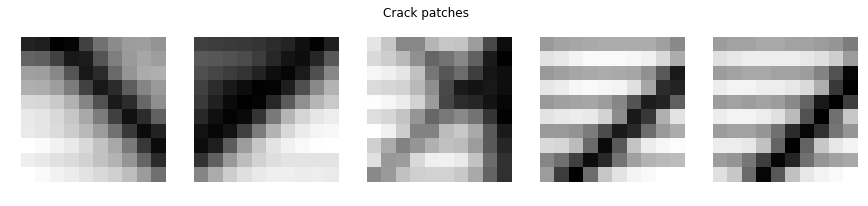

In [30]:
f, axs = plt.subplots(1, 5, figsize = (15, 3))
for ax in axs:
    ax.imshow(patch_data['cracks'][np.random.randint(patch_data['cracks'].shape[0])],
              cmap = 'gray'); ax.axis('off');
f.suptitle('Crack patches');

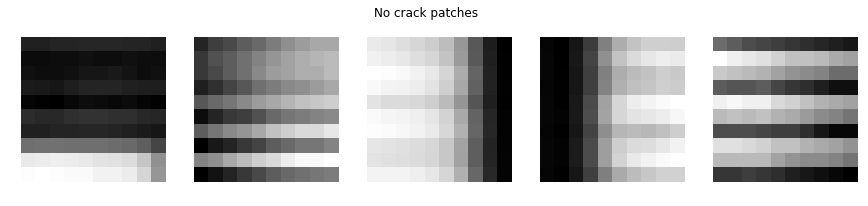

In [31]:
f, axs = plt.subplots(1, 5, figsize = (15, 3))
for ax in axs:
    ax.imshow(patch_data['nocracks'][np.random.randint(patch_data['nocracks'].shape[0])],
              cmap = 'gray'); ax.axis('off');
f.suptitle('No crack patches');